In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("lstm_data.parquet")
df.head()

,player_id,t,x,y,team_id,video_id
0,1,0,6909.913574,3487.211914,0,4
1,1,1,6910.418945,3486.980713,0,4
2,1,2,6911.520996,3489.236328,0,4
3,1,3,6918.666992,3495.847412,0,4
4,1,4,6924.256348,3485.712402,0,4


In [3]:
df_2 = df[(df['video_id']==4) & (df['team_id']==0) & (df['player_id']==3)].copy()
len(df_2)

750

In [4]:
int(len(df_2)*0.95)

712

In [5]:
col = ['x','y']

df_for_training = df_2[col][0:712].copy()

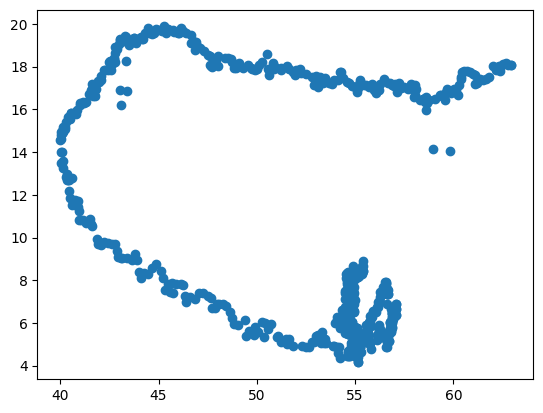

In [6]:
plt.scatter(df_for_training['x']*108/12000,df_for_training['y']*65/7000)
plt.show()

In [7]:
df_for_training.head(),len(df_for_training)

(                x            y
 1500  6991.204590  1946.742554
 1501  6991.879395  1946.591797
 1502  6977.893555  1949.191406
 1503  6964.430664  1956.072998
 1504  6949.369629  1950.519897,
 712)

In [8]:
df_for_training = df_for_training.astype('float64')
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 1500 to 2211
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       712 non-null    float64
 1   y       712 non-null    float64
dtypes: float64(2)
memory usage: 16.7 KB


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# Assuming df_for_training is your original DataFrame
ss = StandardScaler()
mm = MinMaxScaler(feature_range=(-1, 1))

# Standardize the DataFrame
df_standardized = ss.fit_transform(df_for_training)

# Scale the standardized DataFrame
df_scaled = mm.fit_transform(df_standardized)

# Convert back to DataFrame
df_standardized = pd.DataFrame(df_standardized, columns=df_for_training.columns)
df_scaled = pd.DataFrame(df_scaled, columns=df_for_training.columns)




In [10]:
df_scaled

,x,y
0,0.999471,0.770515
1,1.000000,0.770337
2,0.989026,0.773406
3,0.978462,0.781529
4,0.966645,0.774974
...,...,...
707,0.230544,-0.766606
708,0.228163,-0.730730
709,0.228359,-0.764238
710,0.224743,-0.758452


In [11]:
# Assuming df is your DataFrame with columns 'x' and 'y'
def create_lstm_dataset(df, past_steps, future_steps):
    X = []
    y = []
    
    for i in range(len(df) - past_steps - future_steps + 1):
        # Get the past sequence for input
        X.append(df[['x', 'y']].iloc[i:i+past_steps].values)
        
        # Get the future sequence for output
        y.append(df[['x', 'y']].iloc[i+past_steps:i+past_steps+future_steps].values)
        
    return np.array(X), np.array(y)

In [12]:
len(df_scaled)-8-4+1

701

In [13]:
# Example usage
past_steps = 8
future_steps = 4

SPLIT = 0.90
(xVal, yVal) = create_lstm_dataset(df_scaled, past_steps, future_steps)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [14]:
X_test[-1]

array([[ 0.25929244, -0.76857626],
       [ 0.25445848, -0.73807599],
       [ 0.24936745, -0.77634239],
       [ 0.24774298, -0.74334784],
       [ 0.24564803, -0.7672873 ],
       [ 0.24292052, -0.79661634],
       [ 0.23688776, -0.76729688],
       [ 0.23054351, -0.76660564]])

In [15]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (630, 8, 2) (630, 4, 2)
Testing Shape: (71, 8, 2) (71, 4, 2)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

In [17]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [18]:
X_test_tensors[-1]

tensor([[ 0.2593, -0.7686],
        [ 0.2545, -0.7381],
        [ 0.2494, -0.7763],
        [ 0.2477, -0.7433],
        [ 0.2456, -0.7673],
        [ 0.2429, -0.7966],
        [ 0.2369, -0.7673],
        [ 0.2305, -0.7666]])

In [19]:
y_test_tensors[-1]

tensor([[ 0.2282, -0.7307],
        [ 0.2284, -0.7642],
        [ 0.2247, -0.7585],
        [ 0.2216, -0.7628]])

In [20]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 8, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 8, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([630, 8, 2]) torch.Size([630, 4, 2])
Testing Shape: torch.Size([71, 8, 2]) torch.Size([71, 4, 2])


In [21]:
X_test_tensors_final[-1]

tensor([[ 0.2593, -0.7686],
        [ 0.2545, -0.7381],
        [ 0.2494, -0.7763],
        [ 0.2477, -0.7433],
        [ 0.2456, -0.7673],
        [ 0.2429, -0.7966],
        [ 0.2369, -0.7673],
        [ 0.2305, -0.7666]])

In [22]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn[-1].view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        out = out.view(x.size(0), 4, 2) # Reshaping the output to (batch_size, 2 steps, 2 features)
        return out

In [23]:
# Define the training loop function
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test, train_loss, test_loss):
    for epoch in range(n_epochs):
        lstm.train()
        optimiser.zero_grad()
        y_pred_train = lstm(X_train)
        loss = loss_fn(y_pred_train, y_train)
        loss.backward()
        optimiser.step()
        
        if epoch % 10 == 0:
            train_loss.append(loss.item())
            
            lstm.eval()
            with torch.no_grad():
                y_pred_test = lstm(X_test)
                test_loss_value = loss_fn(y_pred_test, y_test).item()  # Correctly convert tensor to scalar here
                test_loss.append(test_loss_value)
                
            print(f"Epoch: {epoch}, train loss: {loss.item():1.5f}, test loss: {test_loss_value:1.5f}")




In [24]:

import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 2 # number of features
hidden_size = 16 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
num_classes = 8 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [25]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [26]:
train_loss = []
test_loss = []
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              train_loss=train_loss,
              test_loss=test_loss)

Epoch: 0, train loss: 0.38705, test loss: 0.40636
Epoch: 10, train loss: 0.35821, test loss: 0.33234
Epoch: 20, train loss: 0.33073, test loss: 0.27054
Epoch: 30, train loss: 0.28957, test loss: 0.21292
Epoch: 40, train loss: 0.22836, test loss: 0.14559
Epoch: 50, train loss: 0.15858, test loss: 0.07195
Epoch: 60, train loss: 0.11794, test loss: 0.02915
Epoch: 70, train loss: 0.08795, test loss: 0.00965
Epoch: 80, train loss: 0.05508, test loss: 0.00280
Epoch: 90, train loss: 0.02555, test loss: 0.00272
Epoch: 100, train loss: 0.00775, test loss: 0.00229
Epoch: 110, train loss: 0.00588, test loss: 0.00236
Epoch: 120, train loss: 0.00312, test loss: 0.00158
Epoch: 130, train loss: 0.00274, test loss: 0.00148
Epoch: 140, train loss: 0.00226, test loss: 0.00128
Epoch: 150, train loss: 0.00206, test loss: 0.00114
Epoch: 160, train loss: 0.00191, test loss: 0.00109
Epoch: 170, train loss: 0.00181, test loss: 0.00108
Epoch: 180, train loss: 0.00174, test loss: 0.00108
Epoch: 190, train loss:

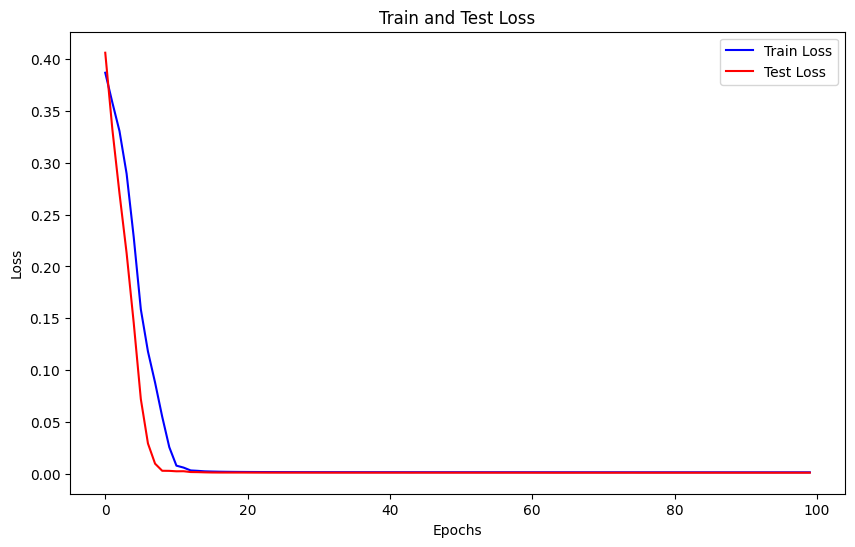

In [27]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, color = 'blue', label='Train Loss')
plt.plot(test_loss, color = 'red', label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.show()

In [28]:
col = ['x','y']

df_all = df_2[col].copy()

# Assuming df_for_training is your original DataFrame
ss = StandardScaler()
mm = MinMaxScaler(feature_range=(-1, 1))

# Standardize the DataFrame
df_standardized = ss.fit_transform(df_all)

# Scale the standardized DataFrame
df_scaled = mm.fit_transform(df_standardized)

# Convert back to DataFrame
df_standardized = pd.DataFrame(df_standardized, columns=df_for_training.columns)
df_scaled = pd.DataFrame(df_scaled, columns=df_for_training.columns)



# split the sequence
df_X_ss, df_y_mm = create_lstm_dataset(df_scaled, 8, 4)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 8, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass


In [29]:
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()


In [30]:
data_predict.shape

(739, 4, 2)

In [31]:
data_predict[0][0]

array([0.9351288, 0.7104784], dtype=float32)

In [32]:
print(data_predict.reshape(-1,2).shape)

(2956, 2)


In [33]:
dataY_plot.shape

(739, 4, 2)

In [34]:
datap = []
datay = []

for i in range(len(data_predict)):
    datap.append(data_predict[i][0])
    datay.append(dataY_plot[i][0])
    
data_predict = np.array(datap)
dataY_plot = np.array(datay)

In [35]:
data_predict

array([[ 0.9351288 ,  0.7104784 ],
       [ 0.92917573,  0.7130587 ],
       [ 0.9209701 ,  0.7087798 ],
       ...,
       [ 0.12387785, -0.7396481 ],
       [ 0.12083169, -0.7369833 ],
       [ 0.11770543, -0.7332469 ]], dtype=float32)

In [36]:
# Inverse transform to original scale 

data_predict = mm.inverse_transform(data_predict) 
data_predict = ss.inverse_transform(data_predict)


dataY_plot  = mm.inverse_transform(dataY_plot ) 
dataY_plot  = ss.inverse_transform(dataY_plot )


In [37]:
len(data_predict[0])

2

In [38]:
true_x, true_y, preds_x, preds_y = [], [], [], []
for i in range(len(dataY_plot)):
    true_x.append(dataY_plot[i][0])
    true_y.append(dataY_plot[i][1])
for i in range(len(data_predict)):
    preds_x.append(data_predict[i][0])
    preds_y.append(data_predict[i][1])

In [39]:
true_x = np.array(true_x)
true_y = np.array(true_y)

preds_x = np.array(preds_x)
preds_y = np.array(preds_y)

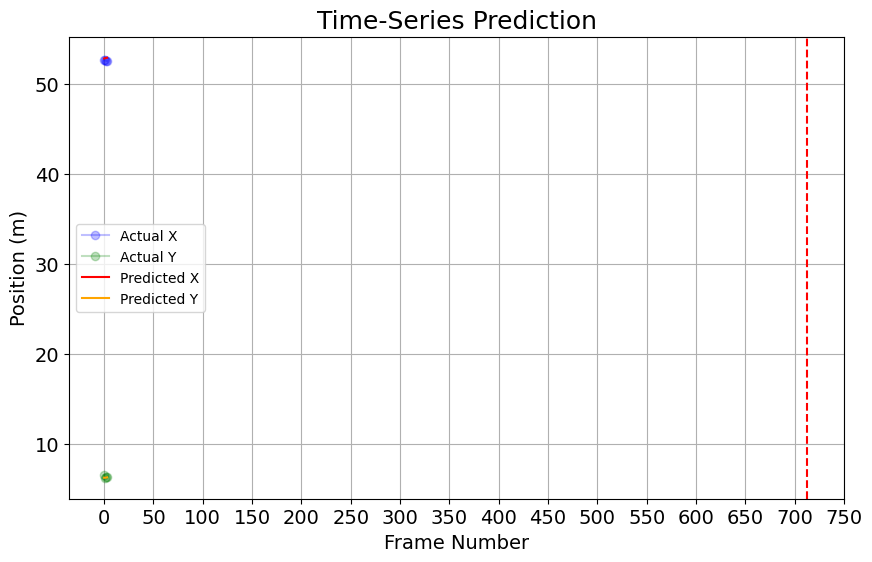

In [73]:
train_test_cutoff = int(len(df_2)*0.95)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true_x*105/12000, label='Actual X',color='blue',marker='o',alpha=0.25) # actual plot
plt.plot(true_y*68/7000, label='Actual Y',color='green',marker='o',alpha=0.25) # actual plot
plt.plot(preds_x*105/12000, '-', label='Predicted X', color = 'red') # predicted plot
plt.plot(preds_y*68/7000, '-', label='Predicted Y', color = 'orange') # predicted plot
plt.title('Time-Series Prediction',fontsize=18)
plt.xlabel('Frame Number',fontsize=14)
plt.ylabel('Position (m)',fontsize=14)
plt.legend()
plt.xticks(np.arange(0,751,50),fontsize=14)
plt.yticks(fontsize=14)
plt.grid
plt.show() 

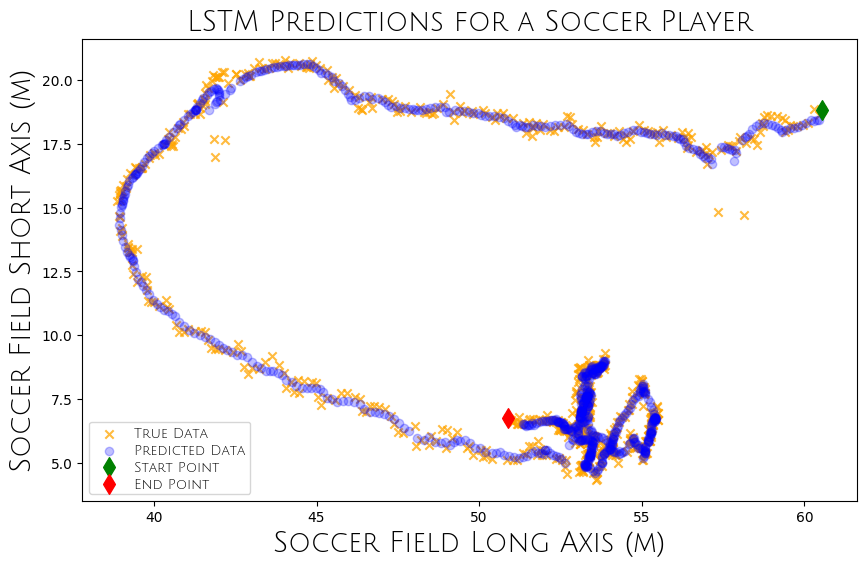

In [49]:
import matplotlib.font_manager as fm
plt.figure(figsize=(10,6))

# Load the specific font
font_path = '/usr/share/fonts/truetype/JuliusSansOne-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path, weight='bold')

plt.scatter(true_x*105/12000, true_y*68/7000, c='orange', marker='x', alpha = 0.75, label='True Data')

# Plot predicted data
plt.scatter(preds_x*105/12000, preds_y*68/7000, c='blue', marker='o', alpha=0.25, label='Predicted Data')

# Mark the beginning and end points
plt.scatter(true_x[0]*105/12000, true_y[0]*68/7000, c='green', marker='d', s=100, label='Start Point')
plt.scatter(true_x[-1]*105/12000, true_y[-1]*68/7000, c='red', marker='d', s=100, label='End Point')

# Optional: Add labels and legend
plt.xlabel('Soccer Field Long Axis (m)', fontproperties=font_prop, fontsize = 20)
plt.ylabel('Soccer Field Short Axis (m)', fontproperties=font_prop, fontsize = 20)
plt.title('LSTM Predictions for a Soccer Player', fontproperties=font_prop, fontsize = 20)

plt.legend(prop=font_prop, fontsize = 20)

# Show plot
plt.show()

In [63]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = test_predict.reshape(-1, 2)
test_predict = mm.inverse_transform(test_predict) 
test_predict = ss.inverse_transform(test_predict)
test_predict = test_predict.tolist()




In [64]:
X_test_tensors[-1].unsqueeze(0)

tensor([[[ 0.2593, -0.7686],
         [ 0.2545, -0.7381],
         [ 0.2494, -0.7763],
         [ 0.2477, -0.7433],
         [ 0.2456, -0.7673],
         [ 0.2429, -0.7966],
         [ 0.2369, -0.7673],
         [ 0.2305, -0.7666]]])

In [65]:
test_predict 

[[6032.36083984375, 645.0371704101562],
 [6036.01806640625, 645.2403564453125],
 [6039.39013671875, 646.7958374023438],
 [6041.91162109375, 648.6968994140625]]

In [66]:
test_predict

[[6032.36083984375, 645.0371704101562],
 [6036.01806640625, 645.2403564453125],
 [6039.39013671875, 646.7958374023438],
 [6041.91162109375, 648.6968994140625]]

In [67]:
test_target = y_test_tensors[-1].detach().numpy() 

In [68]:
test_target = test_target.reshape(-1,2)
test_target = mm.inverse_transform(test_target) 
test_target = ss.inverse_transform(test_target)
test_target = test_target.tolist()

In [69]:
test_target   

[[6008.208984375, 674.9925537109375],
 [6008.458984375, 646.6063842773438],
 [6003.8505859375, 651.5079956054688],
 [5999.8017578125, 647.7966918945312]]

In [70]:
test_target[0][0]

6008.208984375

In [71]:
true_x, true_y, preds_x, preds_y = [], [], [], []
for i in range(len(test_target)):
    true_x.append(test_target[i][0])
    true_y.append(test_target[i][1])
for i in range(len(test_predict)):
    preds_x.append(test_predict[i][0])
    preds_y.append(test_predict[i][1])

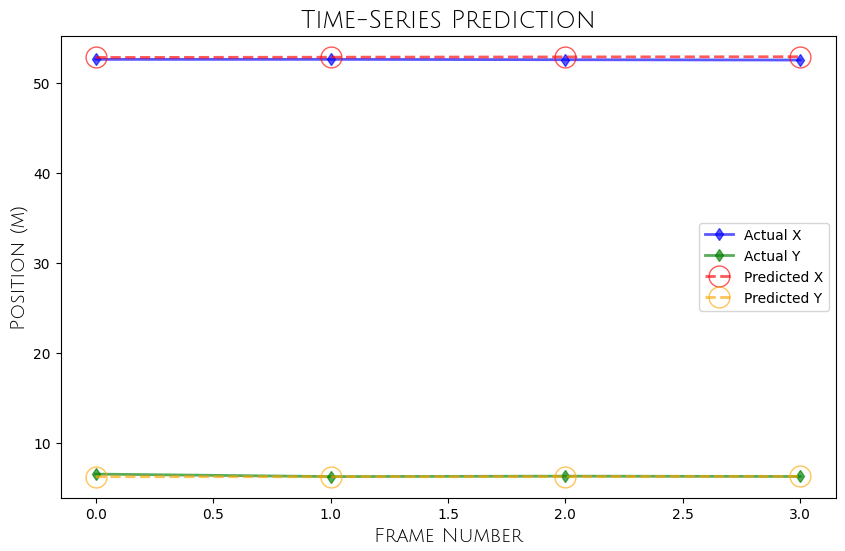

In [79]:
true_x = np.array(true_x)
true_y = np.array(true_y)

preds_x = np.array(preds_x)
preds_y = np.array(preds_y)


plt.figure(figsize=(10,6)) #plotting
# Load the specific font
font_path = '/usr/share/fonts/truetype/JuliusSansOne-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path, weight='bold')

plt.plot(true_x*105/12000,'-d', lw=2,label='Actual X',color='blue',alpha=0.65) # actual plot
plt.plot(true_y*68/7000,'-d', lw=2,label='Actual Y',color='green',alpha=0.65) # actual plot
plt.plot(preds_x*105/12000, '--o',lw=2, markersize=15, fillstyle='none',label='Predicted X', color = 'red',alpha=0.65) # predicted plot
plt.plot(preds_y*68/7000, '--o', lw=2,markersize=15, fillstyle='none',label='Predicted Y', color = 'orange',alpha=0.65) # predicted plot
plt.title('Time-Series Prediction',fontproperties=font_prop,fontsize=18)
plt.xlabel('Frame Number',fontproperties=font_prop,fontsize=14)
plt.ylabel('Position (m)',fontproperties=font_prop,fontsize=14)
plt.legend()
plt.show() 

In [ ]:
col = ['x','y']

df_for_training = df_2[col].copy()

In [ ]:
# Assuming df_for_training is your original DataFrame
ss = StandardScaler()
mm = MinMaxScaler(feature_range=(-1, 1))

# Standardize the DataFrame
df_standardized = ss.fit_transform(df_for_training)

# Scale the standardized DataFrame
df_scaled = mm.fit_transform(df_standardized)

# Convert back to DataFrame
df_standardized = pd.DataFrame(df_standardized, columns=df_for_training.columns)
df_scaled = pd.DataFrame(df_scaled, columns=df_for_training.columns)

In [ ]:
df_scaled_2 = df_scaled[738:746]

In [ ]:
df_scaled_2

In [ ]:
df_scaled[746:]

In [ ]:
test_x = df_scaled_2.to_numpy()

In [ ]:
test_x

In [ ]:
test_x_t = torch.Tensor(test_x)

In [ ]:
test_x_t.shape

In [ ]:
test_x_tt = torch.reshape(test_x_t, (1, 8, test_x_t.shape[1]))

In [ ]:
test_x_tt.shape

In [ ]:
test_x_tt

In [ ]:
final = lstm(test_x_tt)
final = final.detach().numpy()
final = final.reshape(-1, 2)
final = mm.inverse_transform(final) 
final = ss.inverse_transform(final)
# final = final.tolist()


In [ ]:
print(final[:,0]*105/12000)
print(final[:,1]*68/7000)

In [ ]:
df_final = df_for_training[746:]
df_final['x']= df_final['x']*105/12000
df_final['y']= df_final['y']*68/7000

df_final 

In [ ]:
plt.figure(figsize=(10,6)) #plotting


plt.plot(df_final['x'].values,'d-', label='Actual X',color='blue') # actual plot
plt.plot(df_final['y'].values,'d-', label='Actual Y',color='green') # actual plot
plt.plot(final[:,0]*105/12000, 'o--',markersize=15, fillstyle='none', label='Predicted X', color = 'red') # predicted plot
plt.plot(final[:,1]*68/7000, 'o--', markersize=15, fillstyle='none',label='Predicted Y', color = 'orange') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 